# NYC's AirBnb

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

## Load and Clean AriBnb Data

In [2]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import pandas as pd
import numpy as np
import plotly.plotly as py
import plotly.graph_objs as go
from geopandas import GeoDataFrame
import seaborn as sns
import requests
import json
from IPython.display import IFrame

In [3]:
listing_data = "Airbnb_Data/Detailed/listings.csv"
listings_df = pd.read_csv(listing_data)
listings_df.shape

(48233, 106)

In [4]:
listings_df.rename(columns = {'neighbourhood_group_cleansed': 'borough'}, inplace = True)
listings_df['price'] = listings_df['price'].str.replace('$', '').str.replace(',', '').astype(float)

organized_df = listings_df[["id", "host_is_superhost", "borough", "zipcode", \
                            "latitude", "longitude", "is_location_exact", "room_type", "accommodates", \
                            "bathrooms", "bedrooms", "beds", "bed_type", "price","number_of_reviews", \
                            "review_scores_rating", "review_scores_cleanliness", "review_scores_checkin", \
                            "review_scores_communication", "review_scores_location", "review_scores_value", \
                            "cancellation_policy"]]
#organized_df = organized_df.dropna()
#organized_df.head()

## I. Geolocation of AriBnb

In [5]:
geo = organized_df.loc[organized_df["is_location_exact"]=="t", ["borough", "zipcode", "latitude", "longitude", "room_type", "price"]]

### geolocation of listings in NYC

In [6]:
mapbox_access_token = 'pk.eyJ1IjoiZ2oyMjk3IiwiYSI6ImNqd2xtaGdoZjA5bTEzeW56ZmM1aDVkaWEifQ.OQ8oKbUco3xfLHxipz0fJA'

data1 = [
    go.Scattermapbox(
        lat=geo["latitude"],
        lon=geo["longitude"],
        mode='markers',
        marker=go.scattermapbox.Marker(
            size=1.3
        ),
    )
]

layout = go.Layout(
    autosize=True,
    hovermode='closest',
    mapbox=go.layout.Mapbox(
        accesstoken=mapbox_access_token,
        bearing=0,
        center=go.layout.mapbox.Center(
            lat=40.7128,
            lon=-74.0060
        ),
        pitch=0,
        zoom=10
    ),
    width=750, 
    height=750
)

fig = go.Figure(data=data1, layout=layout)
#py.iplot(fig, filename='AirBnb in NYC')

IFrame('https://plot.ly/~gj2297/4', width=750, height=750)

## II. Number of AirBnb in NYC and each Borough

### Total Number of AirBnb in NYC

In [7]:
total_AirBnb = len(organized_df)
print(f"The total listings in NYC is {total_AirBnb}.")

The total listings in NYC is 48233.


### Number of AirBnb in each Borough

In [8]:
num_by_borough = pd.DataFrame(organized_df["borough"].value_counts())
num_by_borough.rename(columns={"borough": "Number of Listings"})

,Number of Listings
Manhattan,21513
Brooklyn,19809
Queens,5521
Bronx,1038
Staten Island,352


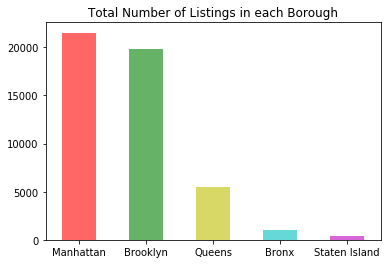

In [9]:
# bar chart: total number of AirBnb in each borough
num_by_borough.plot.bar(color = "rgycm", alpha = 0.6)
plt.xticks(rotation = 0)
plt.legend().remove()
plt.title("Total Number of Listings in each Borough")
plt.savefig("Images/Total Number of Listings in each Borough.png")
plt.show()

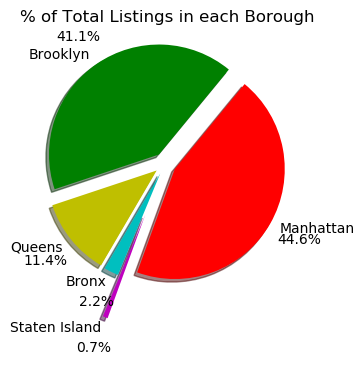

In [10]:
# pie chart: % of total AirBnb in each borough
labels = num_by_borough.index
sizes = num_by_borough["borough"]
explode = (0.1, 0.1, 0.1, 0.1, 0.5)
figure(num=None, figsize=(4, 4), dpi=100, facecolor='w', edgecolor='k')
plt.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', shadow=True, startangle=250, colors="rgycm", \
       pctdistance=1.3, labeldistance=1.1)
plt.axis('equal')
plt.title("% of Total Listings in each Borough")
plt.savefig("Images/% of Total Listings in each Borough.png")
plt.show()

### Number of Listings by Zipcode

In [11]:
#read in shape file
zip_codes = GeoDataFrame.from_file('ZIP_CODE_040114/ZIP_CODE_040114.shp')
zip_codes = zip_codes.rename(columns={"ZIPCODE": "zipcode"})
#zip_codes.head()

In [12]:
#converting zipcode column to string data type
organized_df['zipcode'] = organized_df['zipcode'].astype(int)
#returns only zip codes that are > or = to 10000
organized_df = organized_df[organized_df["zipcode"]>=10000]
organized_df['zipcode'] = organized_df['zipcode'].astype(str)
num_by_zipcode = organized_df["zipcode"].value_counts()
num_by_zipcode = pd.DataFrame({"zipcode": num_by_zipcode.index, "count": num_by_zipcode.values})
#num_by_zipcode.head()

In [13]:
zip_count = GeoDataFrame(pd.merge(num_by_zipcode, zip_codes, how='left', on='zipcode'))
zip_count = zip_count.dropna()
#zip_count.head()

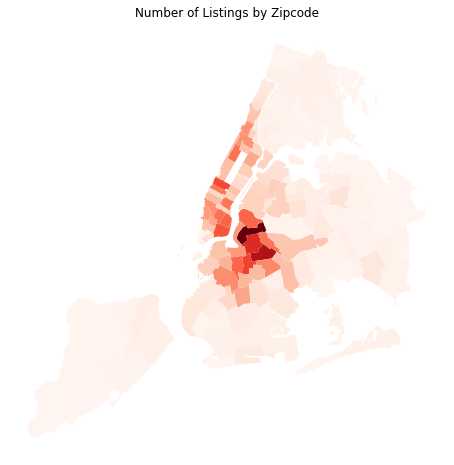

In [14]:
#Plotting the data
fig, ax = plt.subplots(figsize = (8,8))
zip_count.plot(column='count', cmap='Reds', alpha=1, ax=ax)
plt.title('Number of Listings by Zipcode')
plt.axis('off')
plt.savefig("Images/Number of Listings by Zipcode.png")
plt.show()

## III. Avg Price in NYC and each Borough

### Avg Price in NYC

In [15]:
#Average Price NYC
avg_price = round(organized_df["price"].mean(), 2)
#sd_price = round(np.std(organized_df["price"]), 2)
print(f"The average AirBnb price in NYC is: ${avg_price}.")
#print(f"The standard deviation of AirBnb price in NYC is: ${sd_price}.")

The average AirBnb price in NYC is: $152.87.


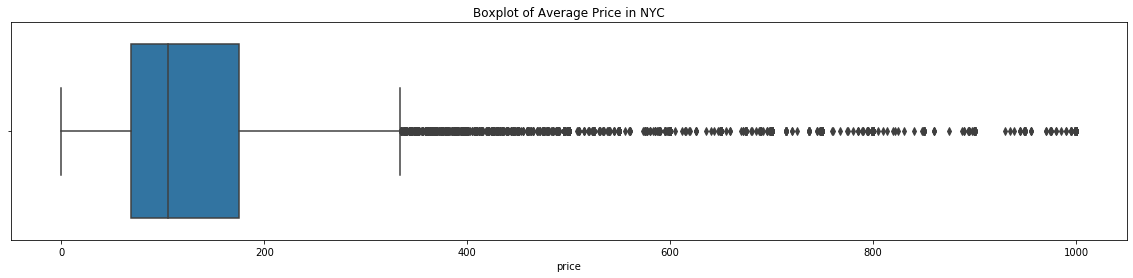

In [16]:
fig, ax = plt.subplots(figsize=(20,4))
price_data = organized_df.loc[organized_df["price"]<=1000]["price"]
ax = sns.boxplot(x=price_data)
plt.title("Boxplot of Average Price in NYC")
plt.savefig("Images/Boxplot of Average Price in NYC")
plt.show()

### Avg Price in each Borough

In [17]:
# Average Price in each borough
average_price = round(organized_df.groupby("borough")["price"].mean(), 2)
average_price = pd.DataFrame(average_price)
average_price = average_price.reindex(["Manhattan", "Brooklyn", "Queens", "Bronx", "Staten Island"])

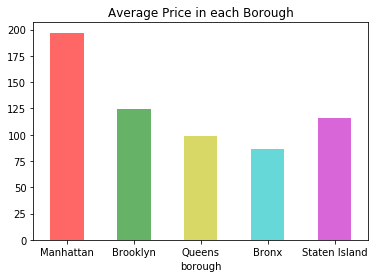

In [18]:
average_price.plot.bar(color = "rgycm", alpha = 0.6)
plt.xticks(rotation = 0)
plt.legend().remove()
plt.title("Average Price in each Borough")
plt.savefig("Images/Average Price in each Borough.png")
plt.show()

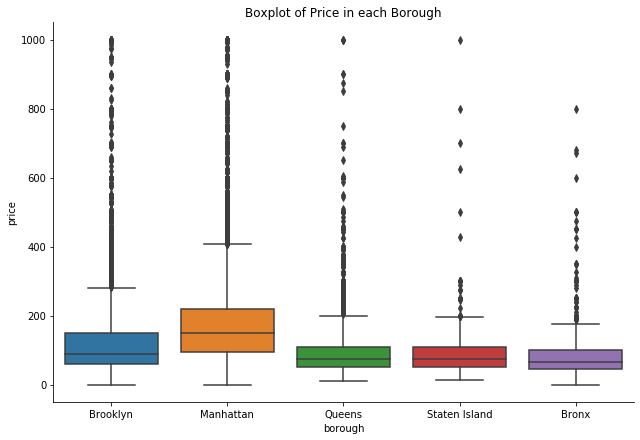

In [19]:
borough_price = organized_df.loc[organized_df["price"]<=1000][["borough", "price"]]
sns.catplot(kind='box', y="price", x="borough", data=borough_price, height=6, aspect=1.5, legend_out=False)
plt.title("Boxplot of Price in each Borough")
plt.savefig("Images/Boxplot Price in each Borough.png")
plt.show()

### Avg Price by Zipcode

In [20]:
avg_price_zipcode = round(organized_df.groupby("zipcode")["price"].mean(), 2)
avg_price_zipcode = pd.DataFrame({"zipcode": avg_price_zipcode.index, "avg price": avg_price_zipcode.values})
zip_price = GeoDataFrame(pd.merge(avg_price_zipcode, zip_codes, how='left', on='zipcode'))
zip_price = zip_price.dropna()
#zip_price.sort_values("avg price", ascending=False)

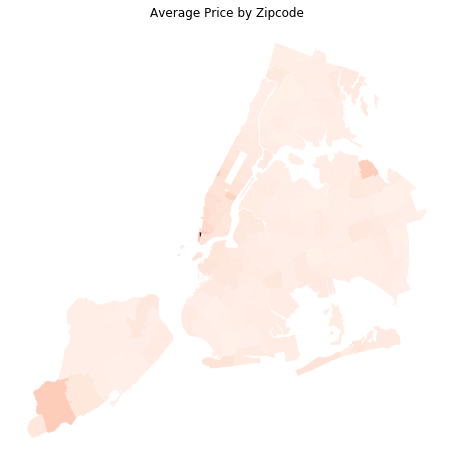

In [21]:
fig, ax = plt.subplots(figsize = (8,8))
zip_price.plot(column='avg price', cmap='Reds', alpha=1, ax=ax)
plt.title('Average Price by Zipcode')
plt.axis('off')
plt.savefig("Images/Average Price by Zipcode.png")
plt.show()

### Price of each Listings

In [22]:
size = geo["price"].values

data3 = [
    go.Scattermapbox(
        lat=geo["latitude"],
        lon=geo["longitude"],
        mode='markers',
        marker=go.scattermapbox.Marker(
            size=size*0.003
        ),
    )
]
fig = go.Figure(data=data3, layout=layout)
#py.iplot(fig, filename='Price of AirBnb in NYC')

IFrame('https://plot.ly/~gj2297/10', width=750, height=750)

### Price Range 

#### Price Range in NYC

In [23]:
bins = list(range(0, 1050, 50))
bins.append(10000)

group_names = [f"{i}-{i+50}" for i in bins]
del group_names[-1]
del group_names[-1]
group_names.append('1000-10000')

organized_df["Price Range ($)"] = pd.cut(organized_df["price"], bins, labels=group_names)

total_airbnb = len(organized_df)
price_sum = organized_df.groupby("Price Range ($)")["id"].count()
percent = round(price_sum / total_airbnb*100, 2)
price_summary = pd.DataFrame({"Number": price_sum, "Percent(%)": percent})
price_summary = price_summary.reset_index()
#price_summary

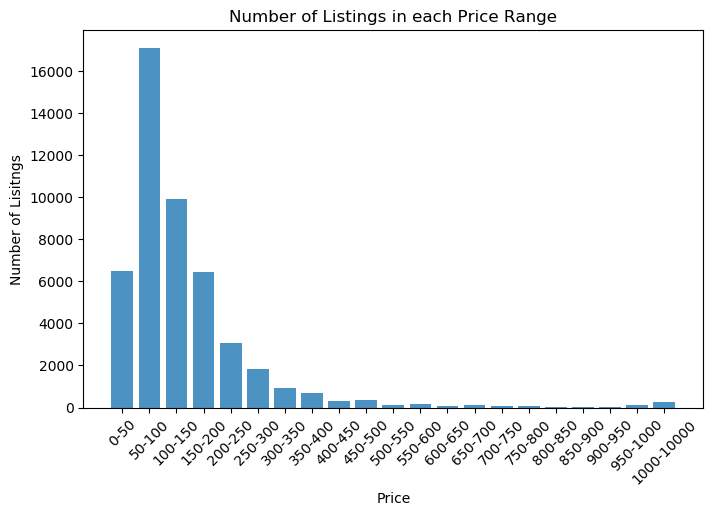

In [ ]:
# bar chart: total number of airbnb in each price range
figure(num=None, figsize=(8, 5), dpi=100, facecolor='w', edgecolor='k')
plt.bar(group_names, price_summary["Number"], alpha = 0.8)
plt.xticks(rotation = 45)
plt.xlabel("Price")
plt.ylabel("Number of Lisitngs")
plt.title("Number of Listings in each Price Range")
plt.savefig("Images/Number of Listings in each Price Range.png")
plt.show()

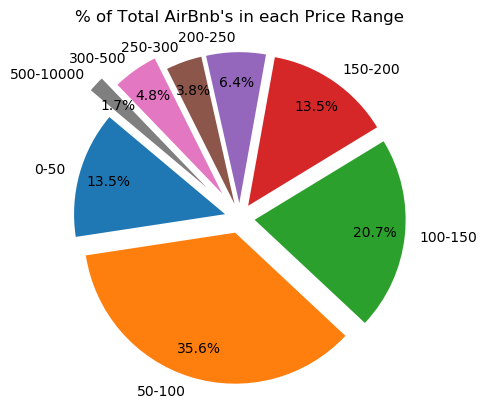

In [ ]:
# pie chart: % of total  airbnb in each price range
sizes = price_summary["Number"].tolist()[0:6]
sizes.append(sum(price_summary["Number"][6:10]))
sizes.append(sum(price_summary["Number"][10:-1]))
labels = group_names[0:6]
labels.append("300-500")
labels.append("500-10000")
explode = (0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.2, 0.3)
#colors = ["red", "orange", "lightcoral", "lightskyblue", "green", "black", "yellow"]
figure(num=None, figsize=(8, 5), dpi=100, facecolor='w', edgecolor='k')
plt.pie(sizes, labels=labels, explode=explode, autopct="%1.1f%%", startangle=140, pctdistance=0.8, labeldistance=1.1)
plt.title("% of Total AirBnb's in each Price Range")
plt.savefig("Images/% of Total AirBnb's in each Price Range.png")
plt.show()

#### Price Range in each Borough

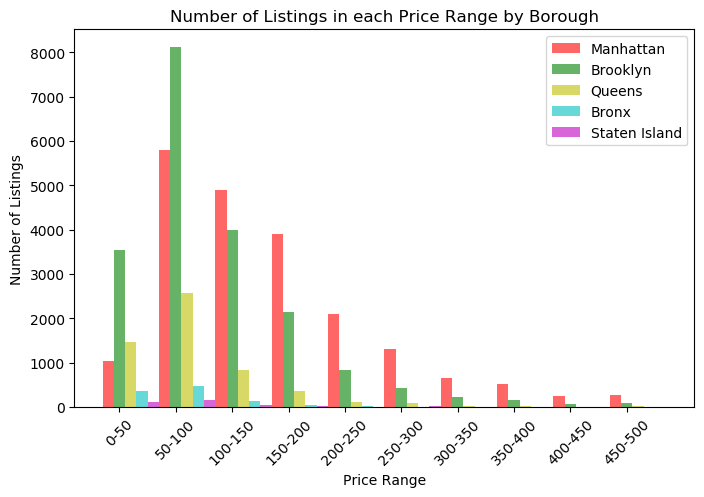

In [ ]:
manhattan = organized_df.loc[organized_df["borough"]=="Manhattan"].groupby("Price Range ($)")["id"].count()[0:10]
brooklyn = organized_df.loc[organized_df["borough"]=="Brooklyn"].groupby("Price Range ($)")["id"].count()[0:10]
queens =  organized_df.loc[organized_df["borough"]=="Queens"].groupby("Price Range ($)")["id"].count()[0:10]
bronx = organized_df.loc[organized_df["borough"]=="Bronx"].groupby("Price Range ($)")["id"].count()[0:10]
staten_island = organized_df.loc[organized_df["borough"]=="Staten Island"].groupby("Price Range ($)")["id"].count()[0:10]

figure(num=None, figsize=(8, 5), dpi=100, facecolor='w', edgecolor='k')

barWidth = 0.2

r1 = np.arange(len(manhattan))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
r4 = [x + barWidth for x in r3]
r5 = [x + barWidth for x in r4]

plt.bar(r1, manhattan, width=barWidth, color="r", alpha = 0.6, label =  "Manhattan")
plt.bar(r2, brooklyn, width=barWidth, color="g", alpha = 0.6, label =  "Brooklyn")
plt.bar(r3, queens, width=barWidth, color="y", alpha = 0.6, label =  "Queens")
plt.bar(r4, bronx, width=barWidth, color="c", alpha = 0.6, label =  "Bronx")
plt.bar(r5, staten_island, width=barWidth, color="m", alpha = 0.6, label =  "Staten Island")
plt.xticks([r + barWidth for r in range(len(manhattan))], group_names[0:10])
plt.xticks(rotation = 45)
plt.xlabel("Price Range")
plt.ylabel("Number of Listings")
plt.title("Number of Listings in each Price Range by Borough")
plt.legend()
plt.savefig("Images/Number of Listings in each Price Range by Borough.png")
plt.show()

## IV. Room Type

### geolocation by room type

In [ ]:
entire_room = go.Scattermapbox(
    lat=geo.loc[geo["room_type"]=="Entire home/apt"]["latitude"].values,
    lon=geo.loc[geo["room_type"]=="Entire home/apt"]["longitude"].values,
    mode='markers',
    name="Entrie home/apt",
    marker=go.scattermapbox.Marker(
        size=1.5,
        color = "orangered"
    ),
)

private_room = go.Scattermapbox(
    lat=geo.loc[geo["room_type"]=="Private room"]["latitude"].values,
    lon=geo.loc[geo["room_type"]=="Private room"]["longitude"].values,
    mode='markers',
    name="Private room",
    marker=go.scattermapbox.Marker(
        size=1.5,
        color = "limegreen"            
    ),
)

shared_room = go.Scattermapbox(
    lat=geo.loc[geo["room_type"]=="Shared room"]["latitude"].values,
    lon=geo.loc[geo["room_type"]=="Shared room"]["longitude"].values,
    mode='markers',
    name="Shared room",
    marker=go.scattermapbox.Marker(
        size=1.5,
        color = "blue"           
    ),
)

data2 = [entire_room, private_room, shared_room]
fig = go.Figure(data=data2, layout=layout)
#py.iplot(fig, filename='AirBnb in NYC by room type')

IFrame('https://plot.ly/~gj2297/6', width=750, height=750)

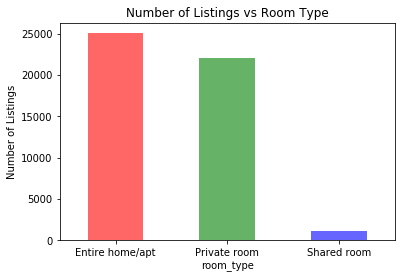

In [ ]:
room_type_num = pd.DataFrame(organized_df.groupby("room_type")["id"].count())
room_type_num.plot.bar(color="rgb", alpha = 0.6)
plt.xticks(rotation = "0")
plt.ylabel("Number of Listings")
plt.title("Number of Listings vs Room Type")
plt.legend().remove()
plt.savefig("Images/Number of Listings vs Room Type.png")
plt.show()

In [ ]:
room_type_price = pd.DataFrame(organized_df.groupby("room_type")["price"].mean())

room_type_price.plot.bar(color = "rgb", alpha = 0.6)
plt.xticks(rotation = "0")
plt.ylabel("Avg Price ($)")
plt.title("Average Price vs Room Type")
plt.savefig("Images/Average Price vs Room Type.png")
plt.show()

In [ ]:
entire_home = organized_df.loc[organized_df["room_type"]=="Entire home/apt"].groupby("Price Range ($)")["id"].count()[0:10]
private_room = organized_df.loc[organized_df["room_type"]=="Private room"].groupby("Price Range ($)")["id"].count()[0:10]
shared_room = organized_df.loc[organized_df["room_type"]=="Shared room"].groupby("Price Range ($)")["id"].count()[0:10]
figure(num=None, figsize=(8, 5), dpi=100, facecolor='w', edgecolor='k')
barWidth = 0.3

r1 = np.arange(len(entire_home))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
plt.bar(r1, entire_home, color="r", width=barWidth, alpha = 0.6, label =  "Entire home/apt")
plt.bar(r2, private_room, color="g", width=barWidth, alpha = 0.6, label =  "Private room")
plt.bar(r3, shared_room, color="b", width=barWidth, alpha = 0.6, label =  "Shared room")
plt.xticks([r + barWidth for r in range(len(entire_home))], group_names[0:10])
plt.xticks(rotation = 45)
plt.xlabel("Price Range")
plt.ylabel("Number of Listings")
plt.title("Number of Listings in each Price Range by Room Type")
plt.legend()
plt.savefig("Images/Number of Listings in each Price Range by Room Type.png")
plt.show()

## Price vs Population

In [ ]:
url = "https://data.cityofnewyork.us/resource/xywu-7bv9.json"
response = requests.get(url)
response_json = response.json()
#print(json.dumps(response_json, indent=4, sort_keys=True))

population=[]
borough=[]
percent = []
for i in range(len(response_json)):
    p = response_json[i]["_2020"]
    b = response_json[i]["borough"]
    per = response_json[i]["_2020_boro_share_of_nyc_total"]
    population.append(p)
    borough.append(b)
    percent.append(per)


population_2020 = pd.DataFrame({"population": population, "borough": borough, "percent": percent})
population_2020

In [ ]:
population_2020.iloc[1:6, 0]

Boroughs = ["Manhattan", "Brooklyn", "Queens", "Bronx", "Staten Island"]
population_2020 = [1638281, 2648452, 2330295, 1446788, 487155]
plt.bar(Boroughs, population_2020, color="rgycm", align="center", alpha = 0.6)
plt.title("2020 Population per Borough")
plt.xlabel("Borough")
plt.ylabel("Number of 2020 population")
plt.savefig("Images/2020 Population per Borough")
plt.show()

In [ ]:
# percent of each borough
AirBnb = [45.1, 40.8, 11.2, 2.1, 0.7]
Population =[19.16, 30.97, 27.25, 16.92, 5.70]
df = pd.DataFrame({'group':["Manhattan", "Brooklyn", "Queens", "Bronx", "Staten Island"], 'AirBnb':AirBnb , 'Population':Population })

ordered_df = df.sort_values(by='AirBnb')
my_range=range(1,len(df.index)+1)

plt.hlines(y=my_range, xmin=ordered_df['AirBnb'], xmax=ordered_df['Population'], color='grey', alpha=0.6)
plt.scatter(ordered_df['AirBnb'], my_range, color='blue', alpha=0.6, label='AirBnb')
plt.scatter(ordered_df['Population'], my_range, color='green', alpha=0.6 , label='Population')
plt.legend()

plt.yticks(my_range, ordered_df['group'])
plt.title('Comparison of the AirBnb and the Population', loc='left')
plt.xlabel('Percent')
plt.ylabel('Borough')
plt.savefig("Images/Comparison of the AirBnb and the Population")
plt.show()

## What drives price?

In [ ]:
data = organized_df[["price", "host_is_superhost", "latitude", "longitude", "room_type", \
                     "accommodates", "bathrooms", "bedrooms", "beds", "bed_type", "number_of_reviews", \
                     "review_scores_rating", "review_scores_cleanliness", "review_scores_checkin", \
                     "review_scores_communication", "review_scores_location", "review_scores_value"]]
data = data.dropna()

superhost = pd.get_dummies(data["host_is_superhost"])
room_type = pd.get_dummies(data["room_type"])
bed_type = pd.get_dummies(data["bed_type"])
data = pd.concat([data, superhost, room_type, bed_type], axis=1, join_axes=[data.index])
data.drop(["host_is_superhost", "room_type", "bed_type", "f"], axis=1, inplace=True)
data = data.rename(columns={"t": "isSuperhost"})
data = data[data["price"]<=1000]
data.head()

In [ ]:
from sklearn.preprocessing import MinMaxScaler
min_max_scaler = MinMaxScaler()
np_scaled = min_max_scaler.fit_transform(data)
data_norm = pd.DataFrame(np_scaled)
listNames = list(data.columns.values)
data_norm.columns = listNames
data_norm.head()

In [ ]:
corr = data_norm.corr()
fig, ax = plt.subplots(figsize=(10,10))
ax = sns.heatmap(corr, vmin=-1, vmax=1, center=0,cmap=sns.diverging_palette(20, 220, n=200), square=True)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.savefig("Images/Correlation.png")
plt.show()

## Price vs Accommodates

In [ ]:
sns.catplot(kind='box', y="price", x="accommodates", data=data, height=6, aspect=1.5, legend_out=False)
plt.xlabel("Number of Accommodates")
plt.title("Boxplot of Price vs Number of Accommodates")
plt.savefig("Images/Boxplot of Price vs Number of Accommodates.png")
plt.show()

## Price vs Beds

In [ ]:
sns.catplot(kind='box', y="price", x="beds", data=data, height=6, aspect=1.5, legend_out=False)
plt.title("Boxplot of Price vs Beds")
plt.savefig("Images/Boxplot of Price vs Beds.png")
plt.show()

## Price vs Bedrooms

In [ ]:
sns.catplot(kind='box', y="price", x="bedrooms", data=data, height=6, aspect=1.5, legend_out=False)
plt.title("Boxplot of Price vs Bedrooms")
plt.savefig("Images/Boxplot of Price vs Bedrooms.png")
plt.show()

## Price vs Bathrooms

In [ ]:
sns.catplot(kind='box', y="price", x="bathrooms", data=data, height=6, aspect=1.5, legend_out=False)
plt.title("Boxplot of Price vs Bathrooms")
plt.savefig("Images/Boxplot of Price vs Bathrooms.png")
plt.show()

## Price vs Review Scores Rating

In [ ]:
sns.scatterplot(y="price", x="review_scores_rating", data = data)
plt.title("Price vs Review Scores Rating")
plt.savefig("Images/Price vs Review Scores Rating")
plt.show()